In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
#Raw Data and Initialization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
import sklearn
#profiler = pd.read_csv("Finalised_Data.csv")
from sklearn import metrics
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
#profiler = pd.read_csv("Finalised_Data.csv")

In [3]:
data = pd.read_csv('Boyd_data.csv')
# transform the training dataset
Features = data.drop(['Temperature', 'Turbidity (FNU)', 'DisOxygen Sat', 'DissOxygen (mg/l)', 'ORP (mV)','Chla_low', "Chla_mean",'Chla_upper','Chla_Sensor','Chla_upper','Chla_Sensor'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(Features[['SpCond (us/cm)', 'pH']],
                                                    data["Chla_mean"], train_size=0.8, random_state=123)

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(profiler[["SpCond (us/cm)", "pH"]],
                                                    profiler["Lab_Chlorophyll (ug/l)"], train_size=0.7, random_state=123)

NameError: name 'profiler' is not defined

In [5]:
#Standardization
from sklearn.preprocessing import MinMaxScaler
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled  = scaler_y.transform(y_test)

In [12]:
#Examine the Default Random Forest to Determine Parameters
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from scipy.stats import pearsonr
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [10]:
#%% Random Search with Cross Validation
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

#pprint(random_grid)

In [7]:
#%% Use the random grid to search for best hyperparameters
# First create the base model to tune
RF_random = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=RF_random, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)
# Fit the random search model
rf_random.fit(X_train_scaled, y_train_scaled);
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.0min
/software/spackages/linux-centos8-x86_64/gcc-8.3.1/anaconda3-2020.07-4obfocw3kpymwz7obsjukroelfwutobz/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 45.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 95.6min finished
/software/spackages/linux-centos8-x86_64/gcc-8.3.1/anaconda3-2020.07-4obfocw3kpymwz7obsjukroelfwutobz/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': True}

In [6]:
#%% EVALUATE FUNCTION
def evaluate(model, X_test_scaled, y_test_scaled):
    predictions = model.predict(X_test_scaled)
    RMSE_RF = metrics.mean_squared_error(y_test_scaled, predictions,squared=True)
    RSQUARED_RF = metrics.r2_score(y_test_scaled, predictions)
    Ht = pd.DataFrame(y_test_scaled)
    Gt = pd.DataFrame(predictions)
    correlation_tr = pearsonr(Ht[0],Gt[0])
    Metrics_RF = [RMSE_RF, RSQUARED_RF,correlation_tr]
    print(Metrics_RF)
    return Metrics_RF

def evaluate_tr(model, X_train_scaled, y_train_scaled):
    predictions = model.predict(X_train_scaled)
    RMSE_RF = metrics.mean_squared_error(y_train_scaled, predictions,squared=True)
    RSQUARED_RF = metrics.r2_score(y_train_scaled, predictions)
    Ht = pd.DataFrame(y_train_scaled)
    Gt = pd.DataFrame(predictions)
    correlation_tr = pearsonr(Ht[0],Gt[0])
    Metrics_RF = [RMSE_RF, RSQUARED_RF,correlation_tr]
    print(Metrics_RF)
    return Metrics_RF

In [15]:
#%% EVALUATING DEFAULT MODEL
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train_scaled, y_train_scaled)
base_accuracy = evaluate(base_model, X_test_scaled, y_test_scaled)
base_accuracy_train = evaluate_tr(base_model, X_train_scaled, y_train_scaled)

<ipython-input-15-99e6dd96a425>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  base_model.fit(X_train_scaled, y_train_scaled)


[0.0004588667045561946, 0.5219971034245328, (0.7362996324572559, 0.0)]
[0.00018271066518719525, 0.8171530398181364, (0.9045391827870526, 0.0)]


In [20]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_scaled, y_test_scaled)
import pickle
# save the model to disk
RF_with_random_selected_variables = 'finalized_model.sav'
pickle.dump(best_random, open(RF_with_random_selected_variables, 'wb'))

[0.0003890285560278265, 0.58791605788416, (0.7681018425499943, 0.0)]


In [7]:
#%% GRID SEARCH FOR BEST HYPERPARAMETERS
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 40, 50],
    'max_features': ['auto'],
    'min_samples_leaf': [1,2],
    'min_samples_split': [9, 10, 12],
    'n_estimators': [1500, 2000,2500]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_train_scaled, y_train_scaled)
grid_search.best_params_
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test_scaled, y_test_scaled)
grid_accuracy_train = evaluate_tr(best_grid, X_train_scaled, y_train_scaled)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was exp

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=1500; total time= 4.8min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=2500; total time= 8.2min


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to 

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=1500; total time= 5.8min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=2000; total time= 8.2min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1500; total time= 5.7min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=2000; total time= 8.5min


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1500; total time= 6.0min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=2000; total time= 8.5min


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was exp

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 6.3min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=2500; total time= 9.0min


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was exp

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 7.9min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time= 7.6min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1500; total time= 5.1min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=2500; total time=10.5min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 6.3min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=2500; total time= 9.3min


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was exp

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=2000; total time= 7.9min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2500; total time=10.0min


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was exp

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=1500; total time= 5.6min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=1500; total time= 5.4min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=2000; total time= 7.4min


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was exp

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=1500; total time= 5.6min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=1500; total time= 6.5min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=2500; total time=10.1min


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was exp

[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=1500; total time= 5.9min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=1500; total time= 6.2min


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was exp

[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=2000; total time= 8.5min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=2000; total time= 7.9min


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was exp

[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2500; total time= 9.7min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=1500; total time= 6.0min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=1500; total time= 5.3min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=2500; total time=10.2min


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was exp

[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=1500; total time= 6.1min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=2000; total time= 7.9min


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was exp

[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 8.3min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1500; total time= 5.4min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=2500; total time= 9.4min


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was exp

[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time= 8.3min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1500; total time= 6.3min


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was exp

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=2500; total time= 7.8min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time= 7.1min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=2000; total time= 7.9min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=2000; total time= 7.9min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=2500; total time=10.3min


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was exp

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=2000; total time= 6.6min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1500; total time= 5.2min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=2000; total time= 7.6min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=2000; total time= 7.4min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2500; total time= 9.3min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2500; total time= 9.9min


/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was exp

[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2500; total time= 9.2min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=1500; total time= 5.8min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=2500; total time=10.2min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time= 8.1min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=2500; total time=10.0min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time= 7.4min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=2500; total time= 9.4min
[CV] END bootstrap=True, max_depth=40

/software/spackages/linux-rocky8-x86_64/gcc-9.5.0/anaconda3-2022.05-zyrazrj6uvrtukupqzhaslr63w7hj6in/lib/python3.9/site-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=9, n_estimators=2000; total time= 7.8min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=2500; total time=10.0min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=9, n_estimators=1500; total time= 6.0min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=12, n_estimators=2000; total time= 7.9min
[CV] END bootstrap=True, max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=12, n_estimators=1500; total time= 6.3min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time= 8.6min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time= 7.0min
[CV] END bootstrap=True, max_depth=4

In [9]:
grid_search.best_params_
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test_scaled, y_test_scaled)
grid_accuracy_train = evaluate_tr(best_grid, X_train_scaled, y_train_scaled)
#Saving model
#RF_with_grid_selected_variables = 'finalized_RFgridmodel.sav'
#pickle.dump(best_grid, open(RF_with_grid_selected_variables, 'wb'))

[0.0003866156137112942, 0.5972612931373215, (0.7736108272408594, 0.0)]
[0.00027887555590243795, 0.720916413863717, (0.8505534554850884, 0.0)]


In [39]:
#Saving model 
import pickle
Pkl_Filename = "RF_Model_bestgrid_Selected_Par.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_grid, file)

In [16]:
#Sensitivity Analysis
X_scaled_te = pd.DataFrame(X_test_scaled)
X_scaled_te.columns = X_test.columns
y_scaled_te = pd.DataFrame(y_test_scaled)
y_scaled_te.columns = y_test.columns

import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(RF_Model_Sel, random_state=1).fit(X_scaled_te, y_scaled_te)
eli5.show_weights(perm, feature_names = X_scaled_te.columns.tolist())
#perm = PermutationImportance(svc).fit(X_test, y_test)
#eli5.show_weights(perm)

Weight,Feature
0.7775 ± 0.0104,pH
0.5256 ± 0.0090,SpCond (us/cm)


In [7]:
#Loading Model
import pickle
Pkl_Filename = "Final Tuned Models/RF_Model_bestgrid_Selected_Par.pkl"
with open(Pkl_Filename, 'rb') as file:  
    best_grid = pickle.load(file)

/software/spackages/linux-centos8-x86_64/gcc-8.3.1/anaconda3-2021.05-5tjen3mrle3pnguoedh4n2stzzsmywn7/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/software/spackages/linux-centos8-x86_64/gcc-8.3.1/anaconda3-2021.05-5tjen3mrle3pnguoedh4n2stzzsmywn7/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [8]:
true_value = y_test
Pred = best_grid.predict(X_test_scaled)
prediction =pd.DataFrame(Pred)
predicted_value = scaler_y.inverse_transform(prediction)
predicted_value = pd.DataFrame(predicted_value)
true_value.columns = y_test.columns
predicted_value.columns = y_test.columns

(array([  0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

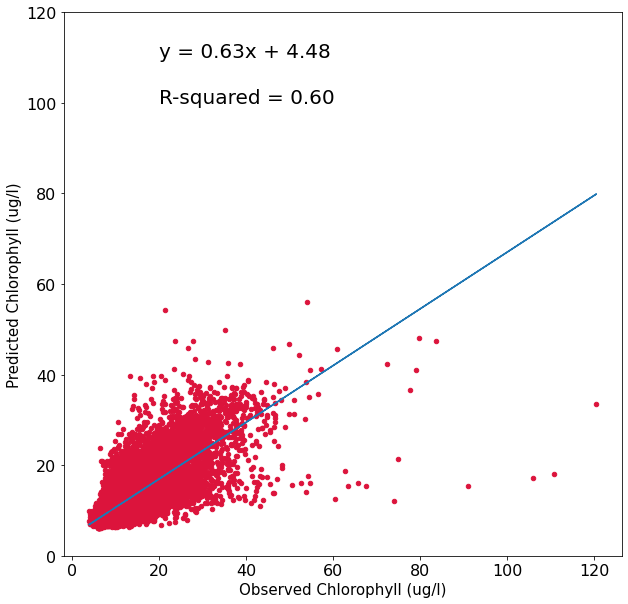

In [13]:
plt.figure(figsize=(10,10))
plt.scatter(true_value ["Lab_Chlorophyll (ug/l)"], predicted_value["Lab_Chlorophyll (ug/l)"], c='crimson',s=20)
x = true_value ["Lab_Chlorophyll (ug/l)"]
y = predicted_value["Lab_Chlorophyll (ug/l)"]
m, b = np.polyfit(x, y, 1)
plt.ylim([0, 120])
plt.plot(x, (m*x)+b, label='y={:.2f}x+{:.2f}'.format(m,b))
plt.xlabel('Observed Chlorophyll (ug/l)', fontsize=15)
plt.ylabel('Predicted Chlorophyll (ug/l)', fontsize=15)
plt.text(20,110, 'y = 0.63x + 4.48', fontsize = 20)
plt.text(20,100, 'R-squared = 0.60', fontsize = 20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [8]:
[m,b]

[0.6253378485827358, 4.478338395213772]